In [88]:
%matplotlib inline
%precision 16
import numpy
import matplotlib.pyplot as plt
import pandas as pd

!pip install yahoo_fin

import pandas as pd
from yahoo_fin.stock_info import get_data
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings("ignore")

In [89]:
%matplotlib inline
%precision 16
import numpy
import matplotlib.pyplot as plt
import pandas as pd
# Provide complete installation or import information for external packages or modules here e.g.

#pip install somepackage
# from somepackage import blah


#!pip install yahoo_fin

import pandas as pd
from yahoo_fin.stock_info import get_data
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings("ignore")

#PAST DJIA
custom_tickers = [
    "^DJI",    # Dow Jones Industrial Average (DJI)
    "^GSPC",   # S&P 500
    "^IXIC",   # NASDAQ Composite
    "^FTSE",   # FTSE 100
    "^RUT",   # RUT
    #"^N225",
    #"^RMCC",
    #"^MID"
]


# Fetch data for each ticker
stock_data = {}
for ticker in custom_tickers:
    try:
        data = get_data(ticker)
        stock_data[ticker] = data
    except AssertionError as e:
        print(f"No data found for {ticker}: {e}")
        
sandp_time = stock_data["^IXIC"]

In [90]:
def lump_sum_strategy(df, initial_investment, interval, moving_averages_df):
        total_investment = len(range(interval, len(df), interval)) * initial_investment
        initial_price = df['close'].iloc[0]  # First available closing price at testing start
        shares_owned = total_investment / initial_price  # Total shares bought at once
        portfolio_value = []
        dates = []
        investment_history = []

        for i in range(0, len(df), interval):
            current_price = df.iloc[i]['close']
            current_value = shares_owned * current_price
            portfolio_value.append(current_value)
            dates.append(df.index[i])
            investment_history.append(0)  # No additional investment made

        return pd.DataFrame({'portfolio_value': portfolio_value, 'investment_history': investment_history}, index=dates)

In [91]:
def lump_sum_with_delay_strategy(df, initial_investment, interval, moving_averages_df, slope_val, days_val):
        global lumpy_date
        initial_in = len(range(interval, len(df), interval)) * initial_investment
        shares_owned = 0
        portfolio_value = []
        dates = []
        investment_history = []
        remaining_investment = 0
        lump_sum_invested = False
        ma_value_peak = moving_averages_df.iloc[0]
        total_investment = 0
        ma_slope = np.gradient(moving_averages_df)

        days = 0
        for i in range(0, len(df), interval):
            current_price = df.iloc[i]['close']

            if i >= len(df)-interval and not lump_sum_invested:
                shares_bought = initial_in / current_price
                shares_owned += shares_bought
                current_value = shares_owned * current_price
                portfolio_value.append(current_value)
                dates.append(df.index[i])
                investment_history.append(total_investment)
                lump_sum_invested = True
                days = 0
                lumpy_date = df.index[i]
            
            if not lump_sum_invested:
                if i >= 10000 or ((ma_slope[i] > slope_val) and days >= days_val):
                    shares_bought = initial_in / current_price
                    shares_owned += shares_bought
                    current_value = shares_owned * current_price
                    portfolio_value.append(current_value)
                    dates.append(df.index[i])
                    investment_history.append(total_investment)
                    lump_sum_invested = True
                    days = 0
                    lumpy_date = df.index[i]
                else:
                    if (ma_slope[i] > 0):
                        days += 1
                    else:
                        days = 0
                    total_investment = 0
            else:
                total_investment = 0

            shares_bought = total_investment / current_price if total_investment > 0 else 0
            shares_owned += shares_bought
            current_value = shares_owned * current_price
            portfolio_value.append(current_value)
            dates.append(df.index[i])
            investment_history.append(total_investment)

        return pd.DataFrame({'portfolio_value': portfolio_value, 'investment_history': investment_history}, index=dates)

In [92]:
def dca_strategy(df, investment_amount, interval):
        shares_owned = 0
        portfolio_value = []
        dates = []
        investment_history = []

        for i in range(0, len(df), interval):
            current_price = df.iloc[i]['close']
            shares_bought = investment_amount / current_price
            shares_owned += shares_bought

            current_value = shares_owned * current_price
            portfolio_value.append(current_value)
            dates.append(df.index[i])
            investment_history.append(investment_amount)

        return pd.DataFrame({'portfolio_value': portfolio_value, 'investment_history': investment_history}, index=dates)

In [93]:
global lumpy_date
lumpy_date = None

def dca_analysis(sandp_time, moving_average_window, time_interval, start_date, end_date, initial_investment, show_graph, slope_val, days_val):
    sandp_time.index = pd.to_datetime(sandp_time.index)

    def lump_sum_strategy(df, initial_investment, interval, moving_averages_df):
        total_investment = len(range(interval, len(df), interval)) * initial_investment
        initial_price = df['close'].iloc[0]  # First available closing price at testing start
        shares_owned = total_investment / initial_price  # Total shares bought at once
        portfolio_value = []
        dates = []
        investment_history = []

        for i in range(0, len(df), interval):
            current_price = df.iloc[i]['close']
            current_value = shares_owned * current_price
            portfolio_value.append(current_value)
            dates.append(df.index[i])
            investment_history.append(0)  # No additional investment made

        return pd.DataFrame({'portfolio_value': portfolio_value, 'investment_history': investment_history}, index=dates)
    
    def lump_sum_with_delay_strategy(df, initial_investment, interval, moving_averages_df, slope_val, days_val):
        global lumpy_date
        initial_in = len(range(interval, len(df), interval)) * initial_investment
        shares_owned = 0
        portfolio_value = []
        dates = []
        investment_history = []
        remaining_investment = 0
        lump_sum_invested = False
        ma_value_peak = moving_averages_df.iloc[0]
        total_investment = 0
        ma_slope = np.gradient(moving_averages_df)

        days = 0
        for i in range(0, len(df), interval):
            current_price = df.iloc[i]['close']

            if i >= len(df)-interval and not lump_sum_invested:
                shares_bought = initial_in / current_price
                shares_owned += shares_bought
                current_value = shares_owned * current_price
                portfolio_value.append(current_value)
                dates.append(df.index[i])
                investment_history.append(total_investment)
                lump_sum_invested = True
                days = 0
                lumpy_date = df.index[i]
            
            if not lump_sum_invested:
                if i >= 10000 or ((ma_slope[i] > slope_val) and days >= days_val):
                    shares_bought = initial_in / current_price
                    shares_owned += shares_bought
                    current_value = shares_owned * current_price
                    portfolio_value.append(current_value)
                    dates.append(df.index[i])
                    investment_history.append(total_investment)
                    lump_sum_invested = True
                    days = 0
                    lumpy_date = df.index[i]
                else:
                    if (ma_slope[i] > 0):
                        days += 1
                    else:
                        days = 0
                    total_investment = 0
            else:
                total_investment = 0

            shares_bought = total_investment / current_price if total_investment > 0 else 0
            shares_owned += shares_bought
            current_value = shares_owned * current_price
            portfolio_value.append(current_value)
            dates.append(df.index[i])
            investment_history.append(total_investment)

        return pd.DataFrame({'portfolio_value': portfolio_value, 'investment_history': investment_history}, index=dates)

    def dca_strategy(df, investment_amount, interval):
        shares_owned = 0
        portfolio_value = []
        dates = []
        investment_history = []

        for i in range(0, len(df), interval):
            current_price = df.iloc[i]['close']
            shares_bought = investment_amount / current_price
            shares_owned += shares_bought

            current_value = shares_owned * current_price
            portfolio_value.append(current_value)
            dates.append(df.index[i])
            investment_history.append(investment_amount)

        return pd.DataFrame({'portfolio_value': portfolio_value, 'investment_history': investment_history}, index=dates)

    # Calculate moving averages for the testing dataset
    testing_df = sandp_time[start_date:end_date]
    full_set = sandp_time#[training_start_date:testing_end_date]
    moving_averages_test = full_set['close'].rolling(window=moving_average_window).mean()[start_date:end_date]
    
    
    # Calculate the investment strategy results on the testing dataset
    lump_sum_result = lump_sum_strategy(testing_df, initial_investment, time_interval, moving_averages_test)
    dca_result = dca_strategy(testing_df, initial_investment, time_interval)
    lump_sum_with_delay_result = lump_sum_with_delay_strategy(testing_df, initial_investment, time_interval, moving_averages_test)
    


    lump_sum_with_delay_value = lump_sum_with_delay_result["portfolio_value"][-1]
    dca_value = dca_result["portfolio_value"][-1]
    lump_sum_value = lump_sum_result["portfolio_value"][-1]

    return [lump_sum_with_delay_value, dca_value, lump_sum_value,lumpy_date]

In [ ]:
# Define parameters
moving_average = 200
time_interv = 21
training_start_date = '2010-12-31'
training_end_date = '2017-12-31'
testing_start_date = '2018-01-01'
testing_end_date = '2024-12-01'
max_val = 10

# Split the dataset into in-sample (training) and out-of-sample (testing)
training_df = sandp_time[training_start_date:training_end_date]
testing_df = sandp_time[testing_start_date:testing_end_date]

# Fit the curve on the training dataset
def exponential_func(x, a, b):
    return a * np.exp(b * x)

x_values_train = np.arange(len(training_df))
y_values_train = training_df['close']
initial_guess = (1.0, 0.001)
popt, pcov = curve_fit(exponential_func, x_values_train, y_values_train, p0=initial_guess)
trendline_train = exponential_func(x_values_train, *popt)

# Apply the trendline to the testing dataset
x_values_test = np.arange(len(testing_df)) + len(training_df)
trendline_test = exponential_func(x_values_test, *popt)
testing_df['Trendline'] = trendline_test

# Calculate moving averages for the testing dataset
moving_averages_test = pd.DataFrame()
full_set = sandp_time[training_start_date:testing_end_date]
moving_averages_test['Moving Average'] = full_set['close'].rolling(window=moving_average_window).mean()[len(full_set)-len(testing_df):]


In [94]:
from datetime import datetime, timedelta

# Parameters
train_years = 1.5
test_years = 1

moving_average_window = 150
time_interval = 5
initial_investment = 10000
show_graph = False
slope_val = 0.001
days_val = 6


start_dates = np.random.choice(sandp_time.loc['2003-01-01':'2024-04-26'].index, size=2000, replace=False)
end_dates = [date + pd.DateOffset(months=int(test_years * 12)) for date in start_dates]


# Collect results
results = []
for start_date, end_date in zip(start_dates, end_dates):
    try:
        result = dca_analysis(sandp_time, moving_average_window, time_interval, start_date, end_date, initial_investment, show_graph, slope_val, days_val)
        result_with_dates = result + [start_date, end_date]
        results.append(result_with_dates)
    except:
        pass

# Convert results into a DataFrame for easier manipulation
results_df = pd.DataFrame(results, columns=['Lump Sum with Delay', 'DCA', 'Lump Sum', 'Lump Sum Date','Start Date', 'End Date'])
results_df['Best Strategy'] = results_df[['Lump Sum with Delay', 'DCA', "Lump Sum"]].idxmax(axis=1)

In [95]:
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta

def generate_features(data):
    features = pd.DataFrame(index=data.index)
    features['close'] = data['close']
    features['moving_average'] = data['close'].rolling(window=200).mean()
    features['volatility'] = data['close'].rolling(window=200).std()
    features['momentum'] = data['close'].pct_change(periods=10)
    features.dropna(inplace=True)
    return features

# Prepare dataset
features = generate_features(sandp_time)
results = pd.DataFrame(results_df, columns=['Start Date', 'End Date', 'Lump Sum with Delay', 'DCA', 'Lump Sum', 'Best Strategy', 'Lump Sum Date'])

# Merge features with results
data = features.join(results['Best Strategy']).dropna()
feature_periods = []

for idx, row in results.iterrows():
    #period_features = features.loc[row['Start Date']:row['End Date']]
    
    new_date = row['Lump Sum Date'] - timedelta(days=365 * train_years)
    period_features = features.loc[new_date:row['Lump Sum Date']]
    
    #period_features["close"] = MinMaxScaler().fit_transform(period_features[["close"]])
    #period_features["moving_average"] = MinMaxScaler().fit_transform(period_features[["moving_average"]])
    #period_features["volatility"] = MinMaxScaler().fit_transform(period_features[["volatility"]])
    #period_features["momentum"] = MinMaxScaler().fit_transform(period_features[["momentum"]])
    feature_periods.append(period_features)
    
results["data"] = feature_periods
#results = results[results["Best Strategy"] != "DCA"]
#results = results.reset_index(drop=True)
results[["Lump Sum with Delay", "DCA", "Lump Sum"]] = results[["Lump Sum with Delay", "DCA", "Lump Sum"]].apply(pd.to_numeric, errors='coerce')
results["ratio"] = results[["Lump Sum with Delay", "DCA", "Lump Sum"]].max(axis=1) / results[["Lump Sum with Delay", "DCA", "Lump Sum"]].apply(lambda x: x.nlargest(2).iloc[-1], axis=1)
# results = results[results["ratio"] >= 1.02]

In [96]:
results

,Start Date,End Date,Lump Sum with Delay,DCA,Lump Sum,Best Strategy,Lump Sum Date,data,ratio


Upper Confidence Bound 3-Armed Bandit

In [98]:
class MultiArmedBandit:
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.counts = [0] * n_arms
        self.values = [0.0] * n_arms
        self.history = [[] for _ in range(n_arms)]  # To store rewards for each strategy

    def select_arm(self, t):
        ucb_values = [0.0] * self.n_arms
        total_counts = sum(self.counts)
        
        for i in range(self.n_arms):
            if self.counts[i] == 0:
                ucb_values[i] = float('inf')
            else:
                average_reward = self.values[i] / self.counts[i]
                ucb_values[i] = average_reward + math.sqrt((2 * math.log(total_counts)) / self.counts[i])

        return np.argmax(ucb_values)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        self.values[chosen_arm] += reward
        self.history[chosen_arm].append(reward)

Round: 1, Strategy: Lump Sum, Reward: 613520.5910523747
Round: 2, Strategy: DCA, Reward: 659401.5888612433
Round: 3, Strategy: DCA, Reward: 592985.6323238962
Round: 4, Strategy: DCA, Reward: 549387.0120369239
Round: 5, Strategy: Lump Sum, Reward: 430185.6037388249
Round: 6, Strategy: DCA, Reward: 511953.3291164447
Round: 7, Strategy: DCA, Reward: 549694.9032117455
Round: 8, Strategy: DCA, Reward: 568500.4988963524
Round: 9, Strategy: DCA, Reward: 555885.5756145421
Round: 10, Strategy: DCA, Reward: 477329.91029527126
Round: 11, Strategy: DCA, Reward: 571118.7453259426
Round: 12, Strategy: DCA, Reward: 385859.1842513878
Round: 13, Strategy: DCA, Reward: 536591.1814216822
Round: 14, Strategy: DCA, Reward: 509550.46902812965
Round: 15, Strategy: DCA, Reward: 536044.2327830516
Round: 16, Strategy: DCA, Reward: 501634.8678385917
Round: 17, Strategy: DCA, Reward: 479666.6657905158
Round: 18, Strategy: DCA, Reward: 554552.6388907157
Round: 19, Strategy: DCA, Reward: 536303.9528803984
Round: 20

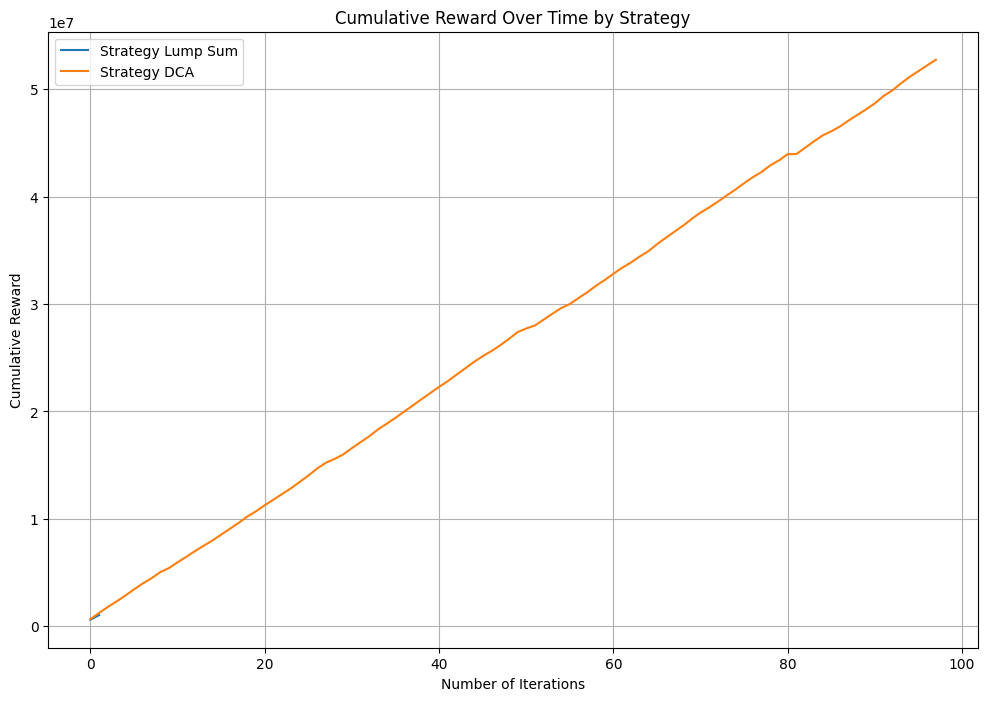

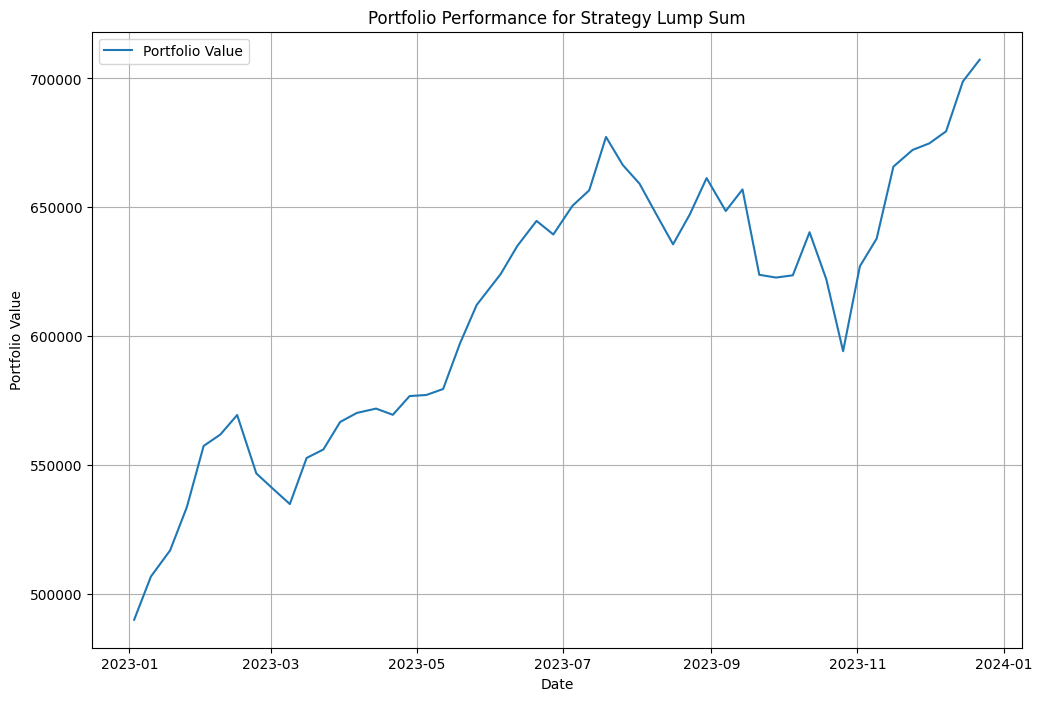

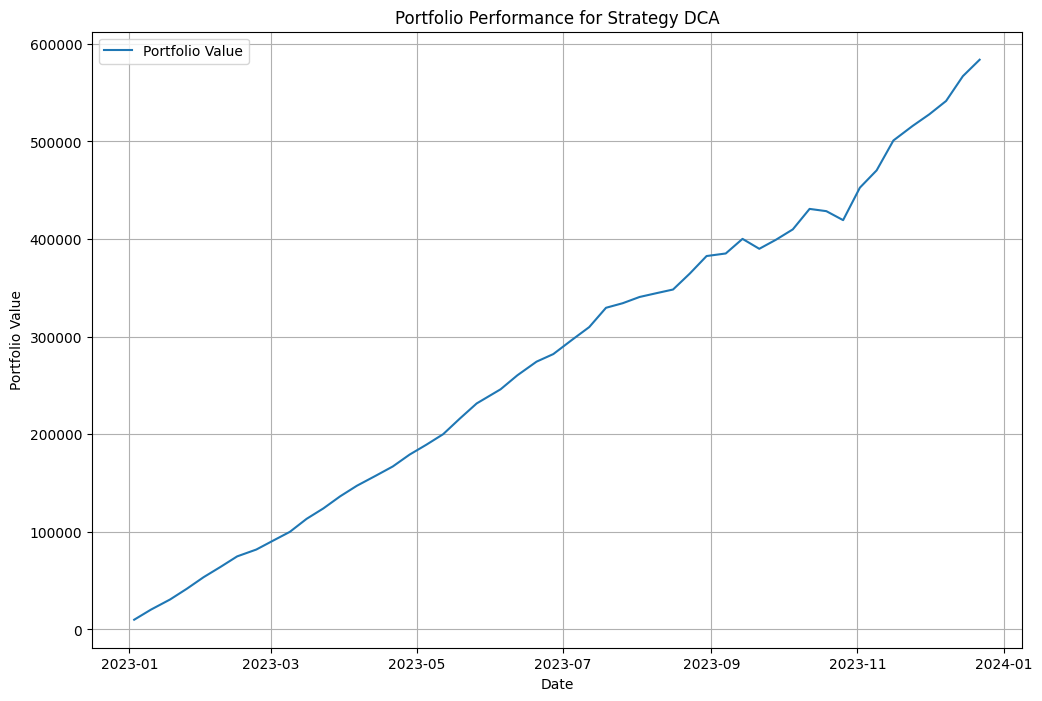

In [99]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_strategy_reward_2strats(strategy_index, sandp_time, moving_average_window, time_interval, initial_investment):
    # Select a random period from the data
    start_date = random.choice(pd.date_range(start='2003-01-01', end='2024-04-26'))
    end_date = start_date + pd.DateOffset(months=12)  # Simulate for one year

    if end_date > pd.to_datetime('2024-04-26'):
        end_date = pd.to_datetime('2024-04-26')
    
    # Prepare data for the selected period
    testing_df = sandp_time[start_date:end_date]
    moving_averages_test = sandp_time['close'].rolling(window=moving_average_window).mean()[start_date:end_date]

    if strategy_index == 0:
        result = lump_sum_strategy(testing_df, initial_investment, time_interval, moving_averages_test)
    elif strategy_index == 1:
        result = dca_strategy(testing_df, initial_investment, time_interval)
    
    return result['portfolio_value'].iloc[-1]  # Return the last value of the portfolio as reward


# Initialize MAB
mab2 = MultiArmedBandit(2)
strats = ["Lump Sum", "DCA"]

# Perform the simulation
n_iterations = 100
for _ in range(n_iterations):
    t = sum(mab2.counts) + 1
    chosen_strategy = mab2.select_arm(t)
    reward = simulate_strategy_reward_2strats(chosen_strategy, sandp_time, moving_average_window, time_interval, initial_investment)
    mab2.update(chosen_strategy, reward)
    print(f"Round: {t}, Strategy: {strats[chosen_strategy]}, Reward: {reward}")

# Plotting the cumulative rewards over time for each strategy
plt.figure(figsize=(12, 8))
for i in range(2):
    plt.plot(np.cumsum(mab2.history[i]), label=f'Strategy {strats[i]}')
plt.legend()
plt.title('Cumulative Reward Over Time by Strategy')
plt.xlabel('Number of Iterations')
plt.ylabel('Cumulative Reward')
plt.grid(True)
plt.show()

# Example of plotting strategy performance over data
def plot_strategy_performance(strategy_index, total_strats):
    # Simulate one period for demonstration
    start_date = pd.to_datetime('2023-01-01')
    end_date = start_date + pd.DateOffset(years=1)
    testing_df = sandp_time[start_date:end_date]
    moving_averages_test = sandp_time['close'].rolling(window=moving_average_window).mean()[start_date:end_date]
    
    if strategy_index == 0:
        result = lump_sum_strategy(testing_df, initial_investment, time_interval, moving_averages_test)
    elif strategy_index == 1:
        result = dca_strategy(testing_df, initial_investment, time_interval)
    elif strategy_index == 2:
        result = lump_sum_with_delay_strategy(testing_df, initial_investment, time_interval, moving_averages_test, slope_val, days_val)

    plt.figure(figsize=(12, 8))
    plt.plot(result.index, result['portfolio_value'], label='Portfolio Value')
    plt.title(f'Portfolio Performance for Strategy {strats[strategy_index]}')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.grid(True)
    plt.legend()
    plt.show()

# Call to plot performance of a specific strategy (e.g., strategy 2)
plot_strategy_performance(0,2)
plot_strategy_performance(1, 1)


Round: 1, Strategy: Lump Sum, Reward: 612145.3082522132
Round: 2, Strategy: DCA, Reward: 516420.9423032591
Round: 3, Strategy: Lump Sum Delay, Reward: 464833.04430273036
Round: 4, Strategy: Lump Sum, Reward: 310605.91367030755
Round: 5, Strategy: DCA, Reward: 584294.7616396653
Round: 6, Strategy: DCA, Reward: 581633.7179037579
Round: 7, Strategy: DCA, Reward: 621288.9813898762
Round: 8, Strategy: DCA, Reward: 656459.8336740219
Round: 9, Strategy: DCA, Reward: 553681.5732183949
Round: 10, Strategy: DCA, Reward: 490823.98456883495
Round: 11, Strategy: DCA, Reward: 505534.2660372791
Round: 12, Strategy: DCA, Reward: 530416.0518781536
Round: 13, Strategy: DCA, Reward: 552393.3033309216
Round: 14, Strategy: DCA, Reward: 516709.5890393241
Round: 15, Strategy: DCA, Reward: 517668.5162579686
Round: 16, Strategy: DCA, Reward: 556353.7861009226
Round: 17, Strategy: DCA, Reward: 597920.6297903493
Round: 18, Strategy: DCA, Reward: 559625.6269205114
Round: 19, Strategy: DCA, Reward: 529650.58984351

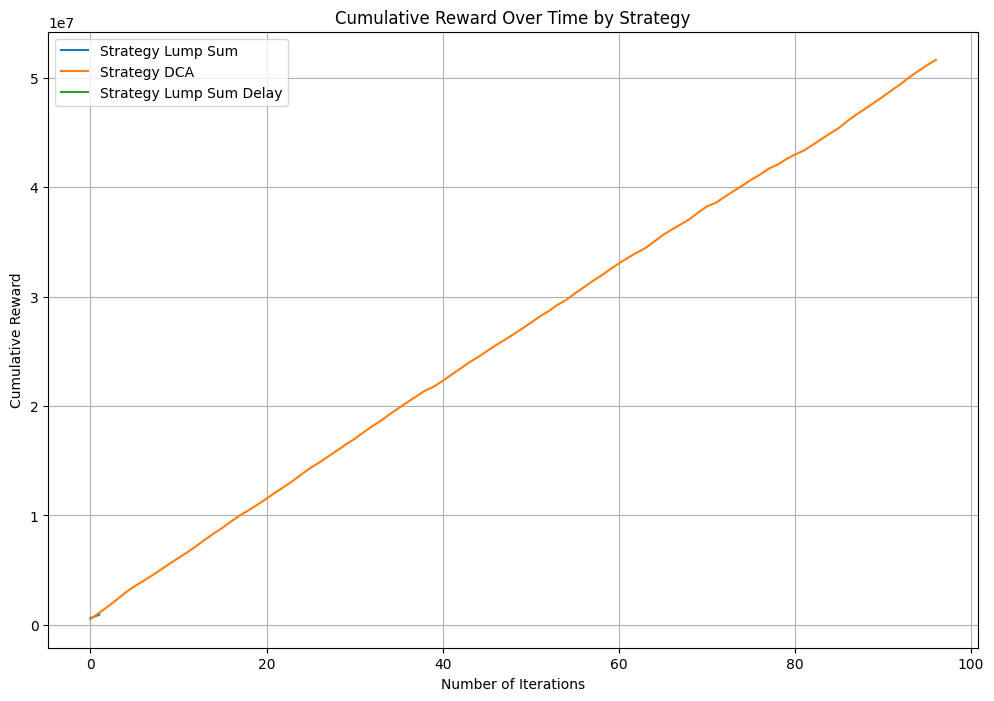

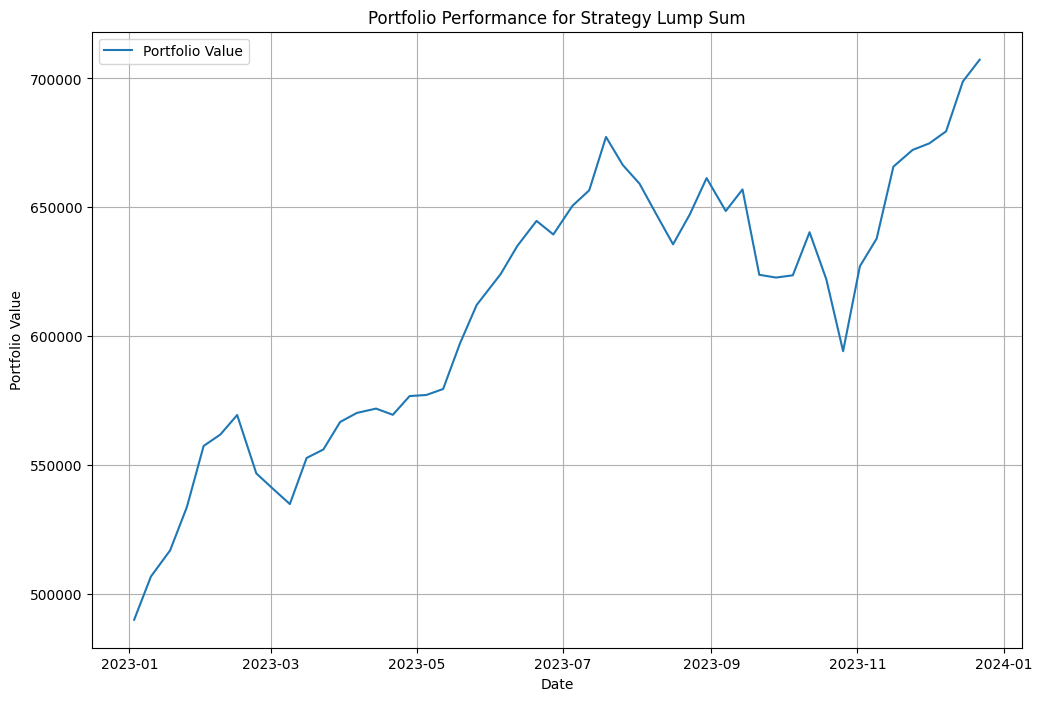

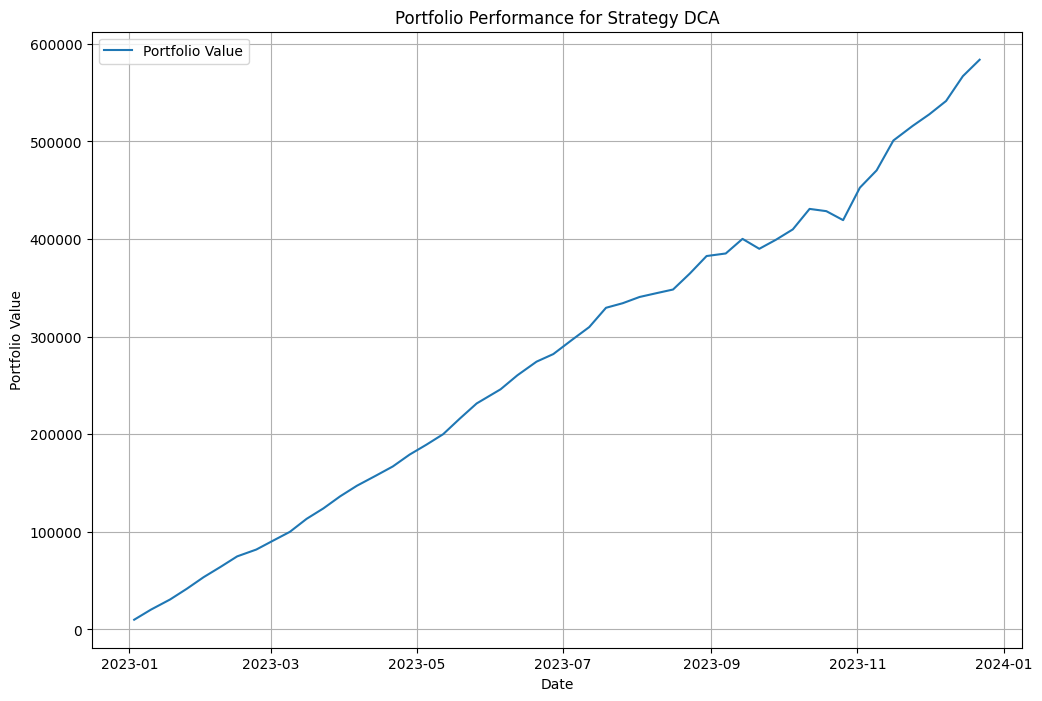

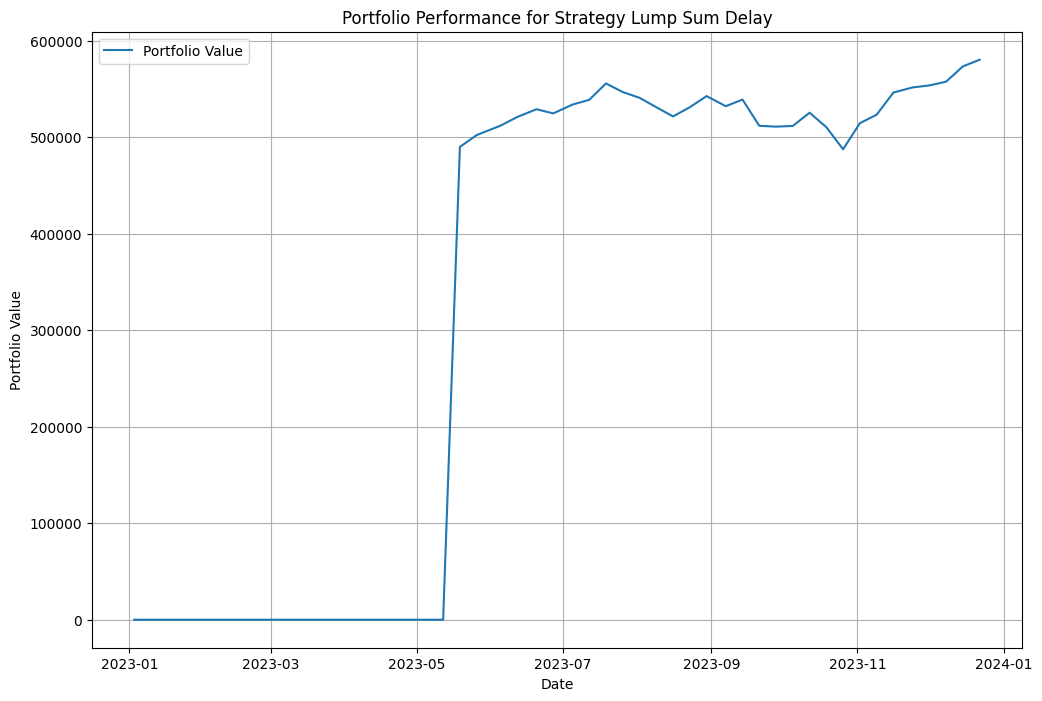

In [100]:
import numpy as np
import matplotlib.pyplot as plt

class MultiArmedBandit:
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.counts = [0] * n_arms
        self.values = [0.0] * n_arms
        self.history = [[] for _ in range(n_arms)]  # To store rewards for each strategy

    def select_arm(self, t):
        ucb_values = [0.0] * self.n_arms
        total_counts = sum(self.counts)
        
        for i in range(self.n_arms):
            if self.counts[i] == 0:
                ucb_values[i] = float('inf')
            else:
                average_reward = self.values[i] / self.counts[i]
                ucb_values[i] = average_reward + math.sqrt((2 * math.log(total_counts)) / self.counts[i])

        return np.argmax(ucb_values)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        self.values[chosen_arm] += reward
        self.history[chosen_arm].append(reward)


def simulate_strategy_reward(strategy_index, sandp_time, moving_average_window, time_interval, initial_investment, slope_val, days_val):
    # Select a random period from the data
    start_date = random.choice(pd.date_range(start='2003-01-01', end='2024-04-26'))
    end_date = start_date + pd.DateOffset(months=12)  # Simulate for one year

    if end_date > pd.to_datetime('2024-04-26'):
        end_date = pd.to_datetime('2024-04-26')
    
    # Prepare data for the selected period
    testing_df = sandp_time[start_date:end_date]
    moving_averages_test = sandp_time['close'].rolling(window=moving_average_window).mean()[start_date:end_date]

    if strategy_index == 0:
        result = lump_sum_strategy(testing_df, initial_investment, time_interval, moving_averages_test)
    elif strategy_index == 1:
        result = dca_strategy(testing_df, initial_investment, time_interval)
    elif strategy_index == 2:
        result = lump_sum_with_delay_strategy(testing_df, initial_investment, time_interval, moving_averages_test, slope_val, days_val)
    
    return result['portfolio_value'].iloc[-1]  # Return the last value of the portfolio as reward



# Initialize MAB
mab = MultiArmedBandit(3)
strats = ["Lump Sum", "DCA", "Lump Sum Delay"]

# Perform the simulation
n_iterations = 100
for _ in range(n_iterations):
    t = sum(mab.counts) + 1
    chosen_strategy = mab.select_arm(t)
    reward = simulate_strategy_reward(chosen_strategy, sandp_time, moving_average_window, time_interval, initial_investment, slope_val, days_val)
    mab.update(chosen_strategy, reward)
    print(f"Round: {t}, Strategy: {strats[chosen_strategy]}, Reward: {reward}")

# Plotting the cumulative rewards over time for each strategy
plt.figure(figsize=(12, 8))
for i in range(3):
    plt.plot(np.cumsum(mab.history[i]), label=f'Strategy {strats[i]}')
plt.legend()
plt.title('Cumulative Reward Over Time by Strategy')
plt.xlabel('Number of Iterations')
plt.ylabel('Cumulative Reward')
plt.grid(True)
plt.show()

# Example of plotting strategy performance over data
def plot_strategy_performance(strategy_index):
    # Simulate one period for demonstration
    start_date = pd.to_datetime('2023-01-01')
    end_date = start_date + pd.DateOffset(years=1)
    testing_df = sandp_time[start_date:end_date]
    moving_averages_test = sandp_time['close'].rolling(window=moving_average_window).mean()[start_date:end_date]
    
    if strategy_index == 0:
        result = lump_sum_strategy(testing_df, initial_investment, time_interval, moving_averages_test)
    elif strategy_index == 1:
        result = dca_strategy(testing_df, initial_investment, time_interval)
    elif strategy_index == 2:
        result = lump_sum_with_delay_strategy(testing_df, initial_investment, time_interval, moving_averages_test, slope_val, days_val)

    plt.figure(figsize=(12, 8))
    plt.plot(result.index, result['portfolio_value'], label='Portfolio Value')
    plt.title(f'Portfolio Performance for Strategy {strats[strategy_index]}')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.grid(True)
    plt.legend()
    plt.show()

# Call to plot performance of a specific strategy (e.g., strategy 2)
plot_strategy_performance(0)
plot_strategy_performance(1)
plot_strategy_performance(2)


In [101]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import random

class ContextualMultiArmedBandit:
    def __init__(self, n_arms, n_features):
        self.n_arms = n_arms
        self.counts = [0] * n_arms
        self.models = [LogisticRegression(max_iter=1000) for _ in range(n_arms)]
        self.data = [np.zeros((0, n_features)) for _ in range(n_arms)]
        self.targets = [[] for _ in range(n_arms)]

    def select_arm(self, features):
        probabilities = np.array([model.predict_proba([features])[0, 1] if self.counts[i] > 0 else float('inf')
                                  for i, model in enumerate(self.models)])
        return np.argmax(probabilities)

    def update(self, chosen_arm, outcome, features):
        self.counts[chosen_arm] += 1
        self.targets[chosen_arm].append(outcome)
        self.data[chosen_arm] = np.vstack([self.data[chosen_arm], features])
        if len(self.targets[chosen_arm]) > 1:
            self.models[chosen_arm].fit(self.data[chosen_arm], self.targets[chosen_arm])

def generate_features(date, data, window):
    """Generate contextual features based on historical data."""
    features = np.array([
        data['close'].rolling(window=window).mean().loc[date],
        data['close'].rolling(window=window).std().loc[date],
        data['close'].pct_change(periods=window).loc[date]
    ])
    return features[np.newaxis, :]  # Return as 2D array for sklearn

def simulate_outcome(chosen_strategy, date, test_data):
    if chosen_strategy==0:
        lump_sum_strategy()
        



# Load data and prepare
data = get_data()  # Placeholder for your data fetching logic
train_cut = int(0.7 * len(data))
train_data = data[:train_cut]
test_data = data[train_cut:]

# Initialize MAB
mab = ContextualMultiArmedBandit(3, 3)

# Training phase
for date in train_data.index:
    features = generate_features(date, train_data, 200)
    chosen_strategy = mab.select_arm(features.flatten())
    outcome = simulate_outcome(chosen_strategy, date, train_data)  # Placeholder for actual outcome simulation
    mab.update(chosen_strategy, outcome, features.flatten())

# Testing phase
test_results = []
for date in test_data.index:
    features = generate_features(date, test_data, 200)
    chosen_strategy = mab.select_arm(features.flatten())
    outcome = simulate_outcome(chosen_strategy, date, test_data)  # Placeholder for actual outcome simulation
    test_results.append((date, chosen_strategy, outcome))

# Analyze test results...


TypeError: get_data() missing 1 required positional argument: 'ticker'